# To-Do



1. Match labels to training data
2. Create k-fold cross-validation



# Imports

### Google Colab

Run these cells only if using Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Create a folder in the root directory
# !mkdir -p "/content/gdrive/My Drive/AI_Thesis"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
%matplotlib widget

### Not Google Colab

Run these cells if not using Google Colab

In [ ]:
!pip install moabb braindecode ipympl

In [ ]:
!pip install tensorflow-gpu
!pip install livelossplot
!pip install git+https://github.com/mvaldenegro/keras-uncertainty.git

# Pre-processing

In [19]:
from braindecode.datasets.moabb import MOABBDataset
import mne
import numpy as np
import pandas as pd
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from numpy import multiply

Download all subject datasets from the BNCI2014001 dataset, also commonly known as BCI Competition IV dataset 2a.

In [ ]:
mne.set_log_level('error')
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=None)

In [ ]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
'''
CHECK IF THE FACTOR IS SAME AS 0.999 MENTIONED IN
THE ARTICLES
'''
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz, iir_params=None, method='iir'),  # Fourth order butterworth filter
    # I think this preprocessor function calls an mne filter object. and in the docs
    # it said iir_params=None and method='iir' means fourth order butterworth will be
    # applied.
    # Apparently when method='iir', the filter is applied twice, once forward and once backwards
    # making it noncausal
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

dataset.description

Preprocess now if you don't want to visualize. I've often forgotten to preprocess and end up scratching my head when I see that there's 26 channels instead of 22 💀💀💀

In [14]:
preprocess(dataset, preprocessors)

### Visualising data before and after pre-processing

In [11]:
dataset.description

,subject,session,run
0,1,session_T,run_0
1,1,session_T,run_1
2,1,session_T,run_2
3,1,session_T,run_3
4,1,session_T,run_4
...,...,...,...
103,9,session_E,run_1
104,9,session_E,run_2
105,9,session_E,run_3
106,9,session_E,run_4


In [12]:
splits = dataset.split("subject")
splits['1'].description

,subject,session,run
0,1,session_T,run_0
1,1,session_T,run_1
2,1,session_T,run_2
3,1,session_T,run_3
4,1,session_T,run_4
5,1,session_T,run_5
6,1,session_E,run_0
7,1,session_E,run_1
8,1,session_E,run_2
9,1,session_E,run_3


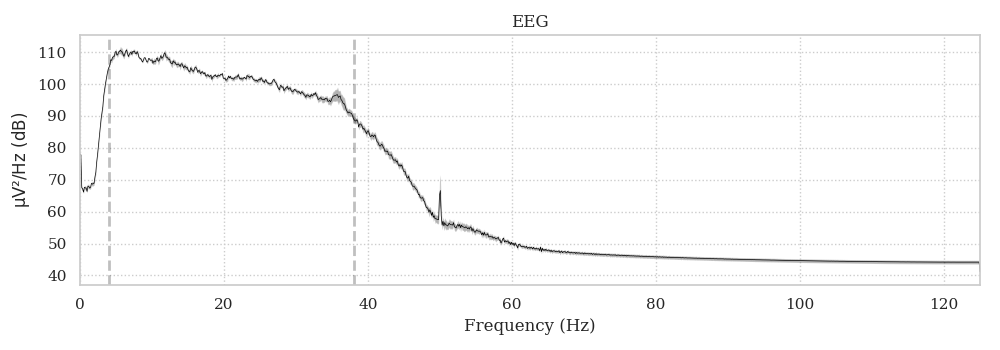

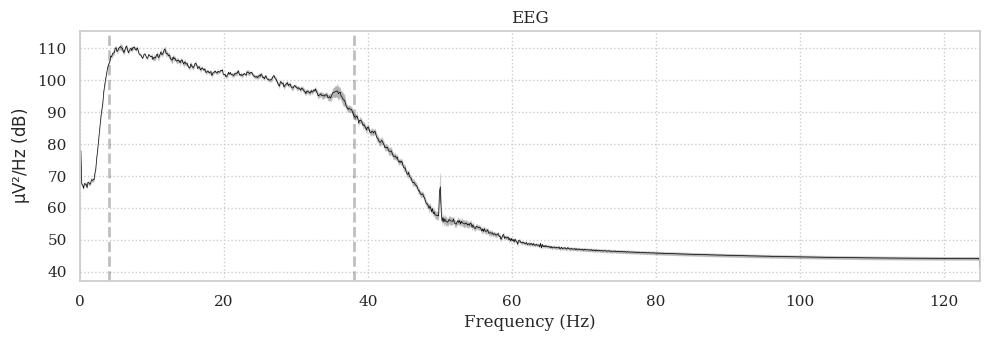

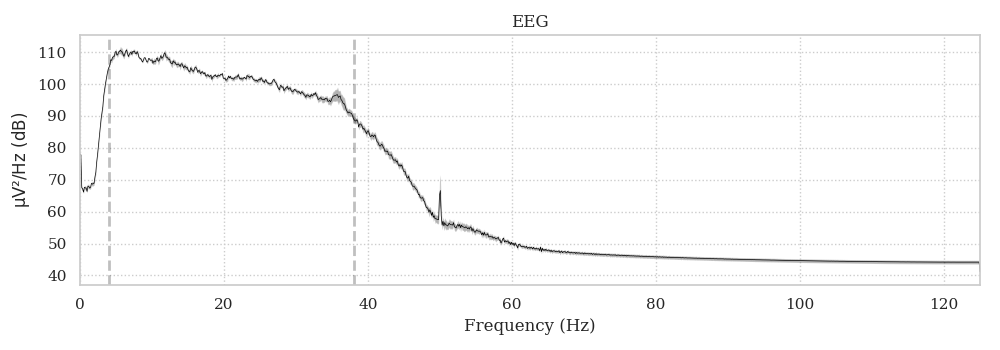

In [13]:
data = splits['1'].datasets[0].raw
spectrum = data.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads")

In [14]:
'''
Preprocess
'''
preprocess(dataset, preprocessors)

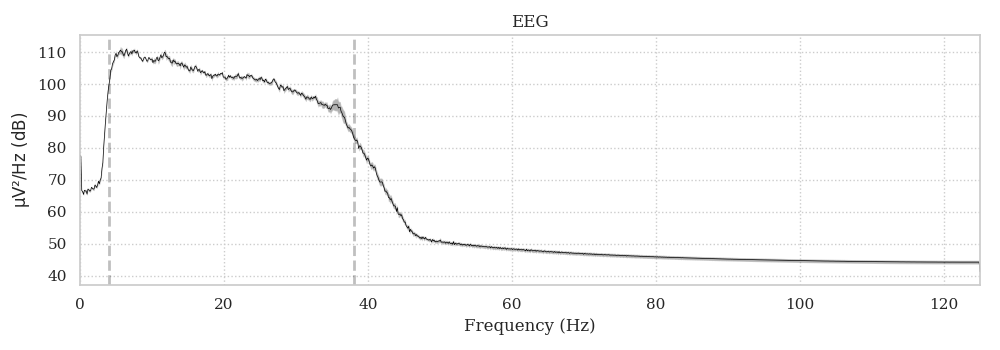

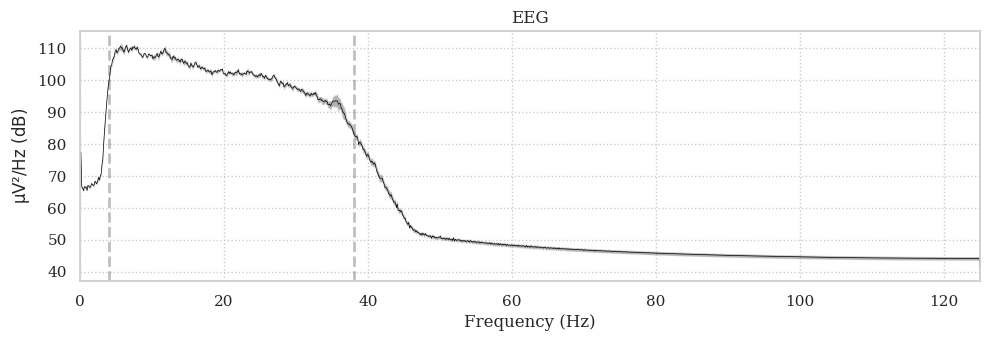

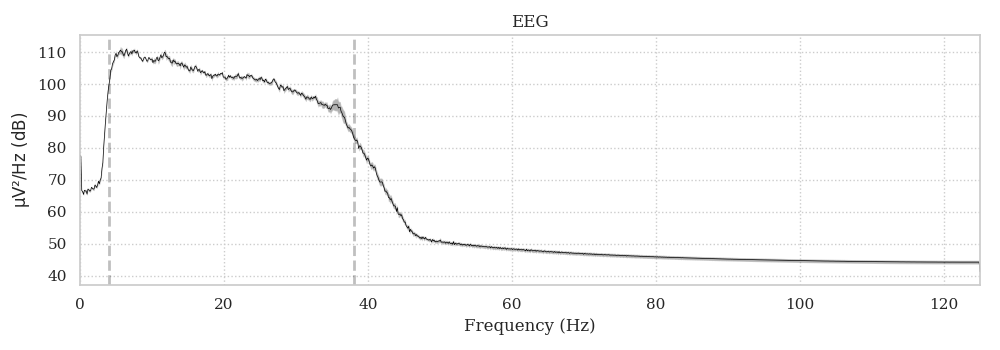

In [15]:
# data = dataset.datasets[0].raw
spectrum = data.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads")

### Epoching

Code from the [tutorial in the API Docs](https://braindecode.org/stable/auto_examples/plot_data_augmentation.html#preprocessing) of braindecode


In [15]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to
# define how trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

### Visualizing the epoched data

Just to confirm

In [17]:
from mne.annotations import events_from_annotations
events = events_from_annotations(dataset.datasets[0].raw)
epochs = windows_dataset.datasets[0].windows

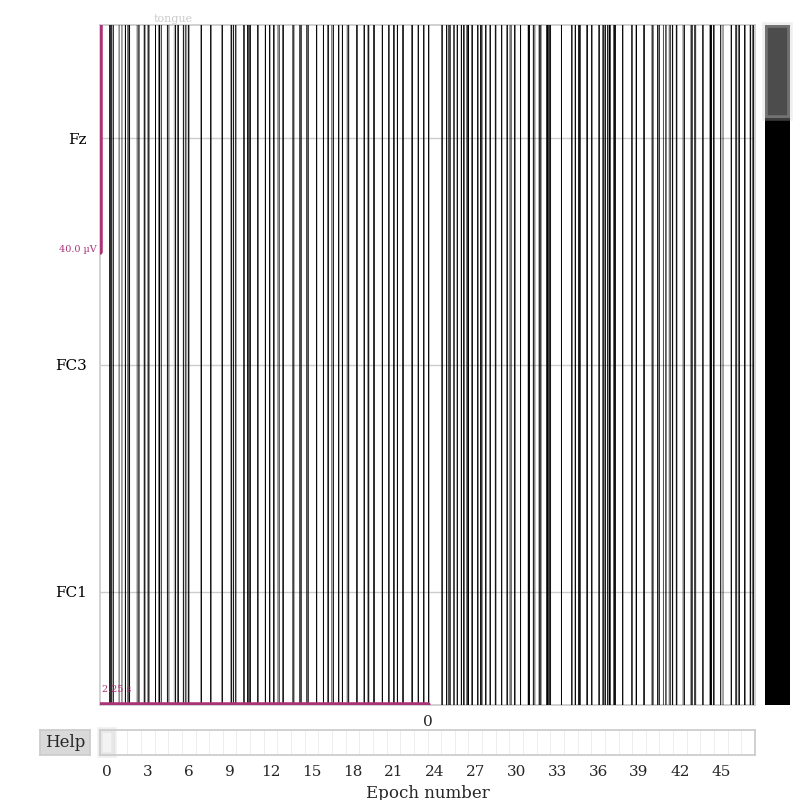

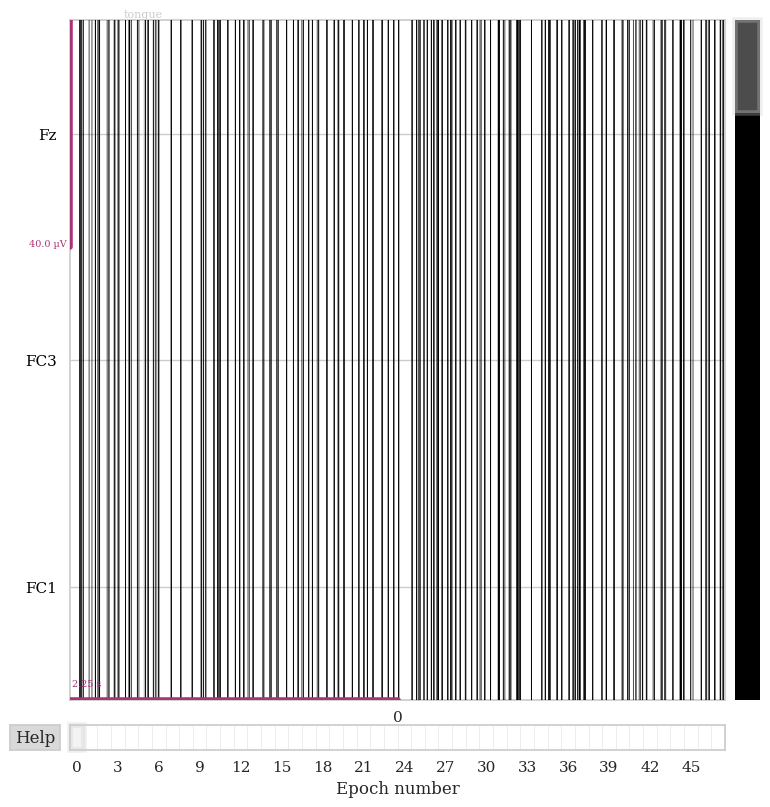

In [18]:
event_dict =  {'feet': 1, 'left_hand': 2, 'right_hand': 3, 'tongue': 4}

epochs.plot(
    n_channels=3,
    n_epochs=1,
    events=events[0],
    event_id=event_dict,
    event_color=dict(feet="red", left_hand="blue", right_hand="green", tongue="yellow"),
    precompute=True
)

Can't see shit, but I can see the lines, so it should be alright? But why's it so jagged...

# Formatting dataset

Code from [link](https://github.com/mauricio-ms/motor-imagery-deep-learning/blob/master/models/bciiviia/cnn1d.py)

Split data by subject so k-fold cross validation can be performed by subject

In [16]:
split_data = windows_dataset.split('subject')

In [17]:
# Expects a BaseConcatDataset object
def create_dataset(dataset):
  # Iterate through subject datasets
  lst = []
  for subject_id in range(0, len(dataset)):
  # Get trial datasets for subjects
    subject_dataset = dataset[subject_id].datasets
    # Iterate through trials
    for run in subject_dataset:
      # Get all epochs from the trial and add to list
      # A single trial (its first element) has shape (22, 1125)
      # Second element of the trial tuple is the class label as
      # an int. I have no idea what the third element is.
      # Some kind of array of three elements. First element is
      # always 0...
      for idx, trial in enumerate(run):
        lst.append(trial)

  # Get all runs in a single df.
  # Drop the weird (0, 625, 1750 column)
  df = pd.DataFrame(lst).drop(columns=2)
  targets = df.pop(1).squeeze()
  inputs = df[0].squeeze()

  return inputs.to_numpy(), targets.to_numpy()


Loop that iterates over each fold in the partition object. Within each iteration, choose a different split of the subjects for training and testing

In [20]:
num_subjects = 9

subject_dataset = [split_data[str(i)] for i in range(1, num_subjects + 1)]

inputs, targets = create_dataset(subject_dataset)

In [ ]:
inputs

Reshaping the arrays from a 1D numpy array of 2D numpy arrays to a single 3D numpy array.

In [28]:
n_runs = len(inputs)
channels = len(inputs[0])
timestamps = len(inputs[0][0])
inputs = np.vstack(inputs).reshape(n_runs, channels, timestamps)


save('all_subjects_runs', inputs, targets)

# Model

After pre-processing is complete and the data has been stored in a file, load data and train the model.

The format of the data is a np array of shape (total_runs_from_all_subjects, n_channels, n_timestamps)

Which translates to (5184, 22, 1125) for this dataset and these params.

In [3]:
import h5py

def save(filename, inputs, targets):
  file = h5py.File(filename + '.h5', 'w')
  file.create_dataset('inputs', data=inputs)
  file.create_dataset('targets', data=targets)
  file.close()


def load(filename):
  file = h5py.File(filename+'.h5', 'r')
  inputs = file['inputs'][:]
  targets = file['targets'][:]
  file.close()
  return inputs, targets

In [4]:
inputs, targets = load('all_subjects_runs')

One-hot encode targets

In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
targets = targets.reshape(-1,1)
targets = encoder.fit_transform(targets)


c:\Users\pithw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
import pandas as pd
import pickle
import tensorflow as tf
from keras_uncertainty.layers import DropConnectDense
from keras_uncertainty.utils import numpy_entropy

Keras Uncertainty will use standalone Keras backend

Maybe convert the epochs to a dataframe
Like:

epcohs_df = windows_dataset.datasets[0].windows.to_data_frame()


Maybe make one of the FC layers use UQ

**SET KERNEL MAXIMUM NORM CONSTRAINT AT 2 AND 0.5 FOR CONVOLUTIONAL AND FC LAYERS RESPECTIVELY**

*Temporal convolution has size of 1 x TimePoints while spatial convolution has size Channels x 1. Spatial convolution is applied after temporal*

In [ ]:
def uncertainty(probs):
  return numpy_entropy(probs, axis=-1)

DropConnectDense(Nc, activation='relu', prob=0.05),
              DropConnectDense(Nc, activation='softmax', kernel_constraint = max_norm(0.5))

In [7]:
print(tf.config.list_physical_devices('GPU'))

[]


In [11]:
def uncertainty(probs):
  return numpy_entropy(probs, axis=-1)


def create_model():

      weights_filepath = 'TBD'

      C = 22          # Number of electrodes
      T = 1125        # Time samples of network input

      k_1 = 40        # K is number of convolutional kernels. SUBJECT TO HYPERPARAM TUNING
      f_1 = 25        # F is kernel size SUBJECT TO HYPERPARAM TUNING
      s_1 = (1,1)     # Strides size
      p_1 = (0,0)     # Padding size

      k_2 = 40
      f_2 = C
      s_2 = (1,1)
      p_2 = (0,0)

      m = 0.9
      alpha = 1
      f_p = (1, 75)   # Fp is pooling size
      s_p = (1, 15)   # Sp is pool stride

      Nc = 4          # Number of classes

      # FIND OUT RIGHT INPUT SHAPE
      model = keras.models.Sequential([
              # keras.layers.Input(shape=(1, C, T)),
              keras.layers.Conv2D(f_1,  k_1, padding = 'SAME',
                                  activation="linear",
                                  input_shape = (C, T, 1),
                                  kernel_constraint = max_norm(2)),
              keras.layers.Conv2D(f_2,  k_2, padding = 'SAME',
                                  input_shape = (1, C, T),
                                  activation="linear",
                                  kernel_constraint = max_norm(2)),

              keras.layers.BatchNormalization(momentum=0.9, epsilon=0.00001),
              keras.layers.ELU(alpha=1.0),
              keras.layers.AveragePooling2D(pool_size= f_p, strides= s_p),
              keras.layers.ELU(alpha=1.0),

              keras.layers.Flatten(),
              DropConnectDense(Nc, activation='softmax', prob=0.05, kernel_constraint = max_norm(0.5))
          ])

      # model.load_weights(weights_filepath)
      optimizer = keras.optimizers.Adam(learning_rate=1e-4)
      model.compile(loss="categorical_crossentropy",
                    optimizer=optimizer, metrics=["accuracy"])
      return model


In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import StochasticClassifier
from livelossplot import PlotLossesKeras

n_epochs= 75
num_subjects = 9
kfold = KFold(n_splits=num_subjects, shuffle=False)

fit_params = {"epochs: ", n_epochs}
early_stopping = EarlyStopping(monitor='loss', patience=3)

acc_per_fold = []
loss_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  if fold_no==2:
    break

  X_train = inputs[train]
  X_test = inputs[test]
  Y_train = targets[train]
  Y_test = targets[test]

  # Define the model architecture
  model = create_model()
  model.fit(X_train, Y_train, epochs=n_epochs, verbose=0,
            callbacks=[early_stopping, PlotLossesKeras()])

  mc_model = StochasticClassifier(model)

  y_pred = model.predict(X_test)
  print(y_pred)
  y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.float32)
  y_pred = tf.argmax(y_pred, axis=1)
  print(y_pred)
  print(y_pred.shape)
  Y_test = tf.argmax(Y_test, axis=1)
  # need to convert y_pred
  entropy = uncertainty(y_pred)

  acc = accuracy_score(Y_test, y_pred)
  print(f'Accuracy and Entropy for {fold_no}: {acc}')
  # Increase fold number
  fold_no = fold_no + 1





# API references

This section is so that I can remember how to achieve something with this library without having to remember it all

[This link documents](https://braindecode.org/stable/auto_examples/plot_dataset_example.html#sphx-glr-auto-examples-plot-dataset-example-py) how all of this is done, including epoching, visualization and creating windows from events (which I'm pretty sure is just epoching).

### How raw data is accessed

In [ ]:
'''
The raw data is accessed like this
'''

from braindecode.datasets.moabb import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

# The actual raw data is stored in dataset.datasets[<session_number>].raw
for data in dataset.datasets:
  print(data.raw)

# Prints the dataset description. For a single subject of BNCI2014 001 dataset,
# This is a dataframe of 12 rows (for a total of 12 sessions)
dataset.description

### Visualisation of raw data

Channels vs Time

In [ ]:
dataset.datasets[0].raw.plot()

### How epoched data is accessed

After using the create_windows_from_events method on the raw data, the returned object is of the WindowsDataset type, a wrapper around the mne.Epochs object. To access the mne.Epochs object and use its methods, simply do:

In [ ]:
windows_dataset.datasets[0].windows